# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
!pip install torch==1.8.1
!pip install torchvision==0.9.1

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 804.1 MB 1.8 kB/s  eta 0:00:01��▎               | 409.4 MB 43.4 MB/s eta 0:00:10MB/s eta 0:00:07     |████████████████████████▉       | 625.1 MB 41.3 MB/s eta 0:00:05     |█████████████████████████▎      | 636.5 MB 41.3 MB/s eta 0:00:05     |███████████████████████████▌    | 692.2 MB 37.2 MB/s eta 0:00:04     |██████████████████████████████▉ | 775.7 MB 36.8 MB/s eta 0:00:01
ERROR: torchvision 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompatible.
ERROR: torchtext 0.12.0 has requirement torch==1.11.0, but you'll have torch 1.8.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 17.4 MB 5.1 MB/s eta 0:00:01


In [1]:
# my imports
import os
import torchvision.transforms

# pre-defined imports
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor


import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

In [3]:
x = [i[-4:] for i in os.listdir('processed_celeba_small/celeba/')]
set(x)

{'.jpg', 'tems', 'tore'}

In [4]:
y = [i for i in os.listdir('processed_celeba_small/celeba/') if i[-4:] == ".jpg"]
len(y) 

32600

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [5]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    #torchvision.transforms.Normalize((0.5,0.5),(0.5,0.5))
    
    # TODO: edit this function by appening transforms to the below list
    transforms = [torchvision.transforms.ToPILImage(),ToTensor(),torchvision.transforms.Resize(size),torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [6]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        
        # TODO: implement the init method
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        
    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        
        onlyfiles = next(os.walk(data_dir))[2] #directory is your directory path as string
        return len(onlyfiles) -1

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        files = [i for i in os.listdir(self.directory) if i[-4:] == ".jpg"]
        img_path = os.path.join(self.directory ,files[index])
       
        image = torchvision.io.read_image(img_path)
        
        image = self.transforms(image)
            
        return image

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

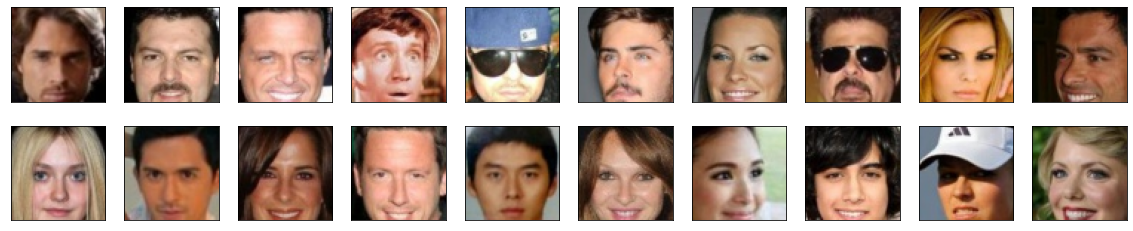

In [8]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [9]:
from torch.nn import Module
import torch.nn as nn

In [10]:
class ConvBlock(Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [11]:
class Discriminator(Module):
    def __init__(self,conv_dim: int):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        
        # complete init function
        self.conv_dim = conv_dim

        # 64x64 input
        self.conv1 = ConvBlock(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 32x32 out
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4)
        # 16x16 out
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4)
        # 8x8 out
        self.conv4 = ConvBlock(conv_dim*4, conv_dim*8, 4)
        # 4x4 out
        
        
        self.last = nn.Conv2d(conv_dim*8, 1,kernel_size= 4, stride=2, padding=0, bias=False)
#         self.last = ConvBlock(conv_dim*4, 1, 4)
        
        self.flatten = nn.Flatten()
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*8*8, 1)
        
        self.sigmoid = nn.Sigmoid() 
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
         # flatten
#         x = self.flatten(x)
        # final output layer
        x = self.last(x) 
        x = self.sigmoid(x)
          
        
        return x 

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL

"""
# run this cell to check your discriminator implementation
discriminator = Discriminator(conv_dim=64)
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [13]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [14]:
class Generator(Module):
    def __init__(self, latent_dim: int, conv_dim: int= 32):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers
        self.deconv1 = DeconvBlock(latent_dim, conv_dim*4, 4, 1, 0)
        self.deconv2 = DeconvBlock(conv_dim*4, conv_dim*2, 4, 2, 1)
        self.deconv3 = DeconvBlock(conv_dim*2, conv_dim, 4, 2, 1)
        self.deconv4 = DeconvBlock(conv_dim, conv_dim//2, 4, 2, 1)
        self.deconv5 = nn.ConvTranspose2d(conv_dim//2, 3, 4, stride=2, padding=1)
        self.last_activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        
        x = self.deconv1(x)
        
        x = self.deconv2(x)
        
        x = self.deconv3(x)
        
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = self.last_activation(x)
        
        return x

In [15]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [16]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(),  0.0002, [0.5, 0.999])
    d_optimizer = optim.Adam(discriminator.parameters(),  0.0002, [0.5, 0.999])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [17]:
def generator_loss(fake_logits,smooth = False):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss
    batch_size = fake_logits.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCELoss()
    # calculate loss
#     print("gen loss")
#     print(f"fake: {fake_logits.squeeze().shape}")
#     print(f"crated : {labels.shape}")
    loss = criterion(fake_logits.squeeze(), labels)
    return loss
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [18]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 
    batch_size = fake_logits.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCELoss()
    # calculate loss
#     print("dis loss")
#     print(f"fake: {fake_logits.squeeze().shape}")
#     print(f"crated : {labels.shape}")
    loss1 = criterion(fake_logits.squeeze(), labels)
    loss2 = generator_loss(real_logits)
    return loss1 + loss2

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [19]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [20]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    g_optimizer.zero_grad()
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    if train_on_gpu:
            z = z.cuda()
    fake_images = generator(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
    
    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
    g_loss.backward()
    g_optimizer.step()
    
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    d_optimizer.zero_grad()
    
    if train_on_gpu:
        real_images = real_images.cuda()
    
    D_real = discriminator(real_images)
    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
        # move x to GPU, if available
    if train_on_gpu:
        z = z.cuda()
    fake_images =generator(z)
    D_fake = discriminator(fake_images.detach())
    d_loss = discriminator_loss(D_real,D_fake)
    
    d_loss.backward()
    d_optimizer.step()
    
    
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    return {'loss': d_loss}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [21]:
from datetime import datetime

In [22]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_on_gpu = torch.cuda.is_available()

# number of epochs to train your model
n_epochs = 5

# number of images in each batch
batch_size = 64

In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50


# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator(conv_dim=64).to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [24]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [25]:
# for batch_i, real_images in enumerate(dataloader):
#     if batch_i % print_every == 0:
#         print(batch_i)

2023-02-11 23:38:02 | Epoch [1/5] | Batch 0/509 | d_loss: 1.4597 | g_loss: 2.2834
2023-02-11 23:38:49 | Epoch [1/5] | Batch 50/509 | d_loss: 0.0062 | g_loss: 7.4158
2023-02-11 23:39:35 | Epoch [1/5] | Batch 100/509 | d_loss: 0.0022 | g_loss: 8.8844
2023-02-11 23:40:25 | Epoch [1/5] | Batch 150/509 | d_loss: 0.0069 | g_loss: 12.4572
2023-02-11 23:41:10 | Epoch [1/5] | Batch 200/509 | d_loss: 0.0123 | g_loss: 8.6508
2023-02-11 23:41:57 | Epoch [1/5] | Batch 250/509 | d_loss: 0.0084 | g_loss: 7.4960
2023-02-11 23:42:43 | Epoch [1/5] | Batch 300/509 | d_loss: 0.0397 | g_loss: 5.0540
2023-02-11 23:43:30 | Epoch [1/5] | Batch 350/509 | d_loss: 0.0132 | g_loss: 6.9361
2023-02-11 23:44:17 | Epoch [1/5] | Batch 400/509 | d_loss: 0.0496 | g_loss: 5.7315
2023-02-11 23:45:05 | Epoch [1/5] | Batch 450/509 | d_loss: 0.6710 | g_loss: 2.2957
2023-02-11 23:45:52 | Epoch [1/5] | Batch 500/509 | d_loss: 0.0457 | g_loss: 5.8428


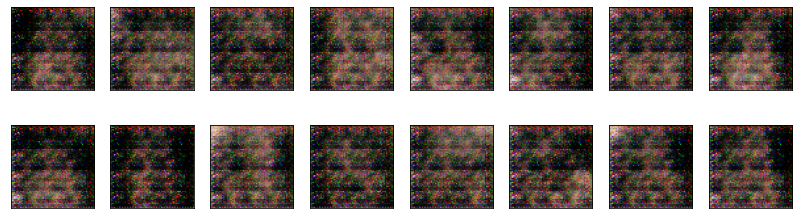

2023-02-11 23:46:03 | Epoch [2/5] | Batch 0/509 | d_loss: 0.0257 | g_loss: 6.4079
2023-02-11 23:46:50 | Epoch [2/5] | Batch 50/509 | d_loss: 0.0564 | g_loss: 5.4466
2023-02-11 23:47:40 | Epoch [2/5] | Batch 100/509 | d_loss: 0.0970 | g_loss: 4.1925
2023-02-11 23:48:26 | Epoch [2/5] | Batch 150/509 | d_loss: 1.2687 | g_loss: 16.2301
2023-02-11 23:49:14 | Epoch [2/5] | Batch 200/509 | d_loss: 0.1251 | g_loss: 7.5235
2023-02-11 23:50:02 | Epoch [2/5] | Batch 250/509 | d_loss: 0.0896 | g_loss: 4.8302
2023-02-11 23:50:48 | Epoch [2/5] | Batch 300/509 | d_loss: 0.0592 | g_loss: 4.9358
2023-02-11 23:51:36 | Epoch [2/5] | Batch 350/509 | d_loss: 0.0738 | g_loss: 4.7925
2023-02-11 23:52:23 | Epoch [2/5] | Batch 400/509 | d_loss: 0.0735 | g_loss: 7.6097
2023-02-11 23:53:13 | Epoch [2/5] | Batch 450/509 | d_loss: 0.0893 | g_loss: 5.8630
2023-02-11 23:53:58 | Epoch [2/5] | Batch 500/509 | d_loss: 0.1503 | g_loss: 5.8961


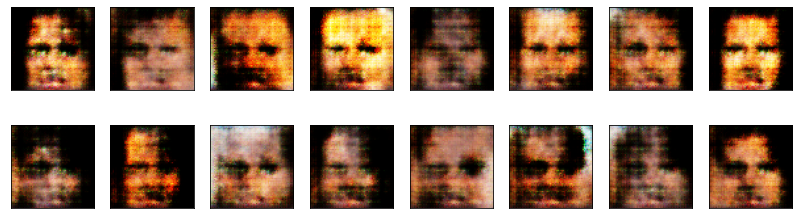

2023-02-11 23:54:10 | Epoch [3/5] | Batch 0/509 | d_loss: 0.0925 | g_loss: 5.2314
2023-02-11 23:54:57 | Epoch [3/5] | Batch 50/509 | d_loss: 0.1178 | g_loss: 8.9519
2023-02-11 23:55:46 | Epoch [3/5] | Batch 100/509 | d_loss: 0.1713 | g_loss: 5.5652
2023-02-11 23:56:32 | Epoch [3/5] | Batch 150/509 | d_loss: 0.0626 | g_loss: 6.2024
2023-02-11 23:57:19 | Epoch [3/5] | Batch 200/509 | d_loss: 0.0990 | g_loss: 6.9070
2023-02-11 23:58:06 | Epoch [3/5] | Batch 250/509 | d_loss: 0.0776 | g_loss: 3.9936
2023-02-11 23:58:53 | Epoch [3/5] | Batch 300/509 | d_loss: 0.1638 | g_loss: 6.3344
2023-02-11 23:59:42 | Epoch [3/5] | Batch 350/509 | d_loss: 0.0728 | g_loss: 9.7558
2023-02-12 00:00:28 | Epoch [3/5] | Batch 400/509 | d_loss: 0.1653 | g_loss: 5.4211
2023-02-12 00:01:17 | Epoch [3/5] | Batch 450/509 | d_loss: 0.2048 | g_loss: 9.3698
2023-02-12 00:02:03 | Epoch [3/5] | Batch 500/509 | d_loss: 0.0985 | g_loss: 4.8025


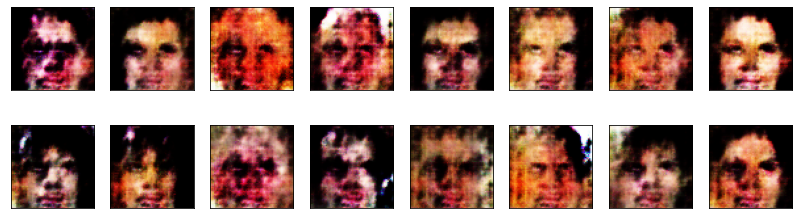

2023-02-12 00:02:15 | Epoch [4/5] | Batch 0/509 | d_loss: 0.1042 | g_loss: 5.7533
2023-02-12 00:03:01 | Epoch [4/5] | Batch 50/509 | d_loss: 0.5915 | g_loss: 12.5791
2023-02-12 00:03:50 | Epoch [4/5] | Batch 100/509 | d_loss: 0.1277 | g_loss: 5.7919
2023-02-12 00:04:36 | Epoch [4/5] | Batch 150/509 | d_loss: 0.0598 | g_loss: 5.5369
2023-02-12 00:05:24 | Epoch [4/5] | Batch 200/509 | d_loss: 0.0426 | g_loss: 7.3858
2023-02-12 00:06:09 | Epoch [4/5] | Batch 250/509 | d_loss: 0.1478 | g_loss: 10.7908
2023-02-12 00:06:59 | Epoch [4/5] | Batch 300/509 | d_loss: 0.0416 | g_loss: 6.3762
2023-02-12 00:07:45 | Epoch [4/5] | Batch 350/509 | d_loss: 0.0272 | g_loss: 7.2174
2023-02-12 00:08:34 | Epoch [4/5] | Batch 400/509 | d_loss: 10.7748 | g_loss: 18.5750
2023-02-12 00:09:18 | Epoch [4/5] | Batch 450/509 | d_loss: 0.2539 | g_loss: 11.1363
2023-02-12 00:10:04 | Epoch [4/5] | Batch 500/509 | d_loss: 0.0505 | g_loss: 5.5834


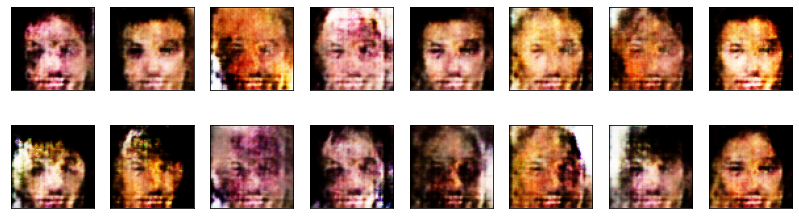

2023-02-12 00:10:16 | Epoch [5/5] | Batch 0/509 | d_loss: 0.0434 | g_loss: 7.6833
2023-02-12 00:11:01 | Epoch [5/5] | Batch 50/509 | d_loss: 0.0844 | g_loss: 6.3998
2023-02-12 00:11:50 | Epoch [5/5] | Batch 100/509 | d_loss: 0.1248 | g_loss: 12.7912
2023-02-12 00:12:34 | Epoch [5/5] | Batch 150/509 | d_loss: 0.0212 | g_loss: 6.9055
2023-02-12 00:13:21 | Epoch [5/5] | Batch 200/509 | d_loss: 0.0162 | g_loss: 6.4495
2023-02-12 00:14:06 | Epoch [5/5] | Batch 250/509 | d_loss: 0.1702 | g_loss: 11.3424
2023-02-12 00:14:52 | Epoch [5/5] | Batch 300/509 | d_loss: 0.0025 | g_loss: 6.6703
2023-02-12 00:15:40 | Epoch [5/5] | Batch 350/509 | d_loss: 0.0882 | g_loss: 5.1361
2023-02-12 00:16:26 | Epoch [5/5] | Batch 400/509 | d_loss: 0.0528 | g_loss: 6.6332
2023-02-12 00:17:15 | Epoch [5/5] | Batch 450/509 | d_loss: 0.0092 | g_loss: 10.6265
2023-02-12 00:18:00 | Epoch [5/5] | Batch 500/509 | d_loss: 0.0085 | g_loss: 9.8437


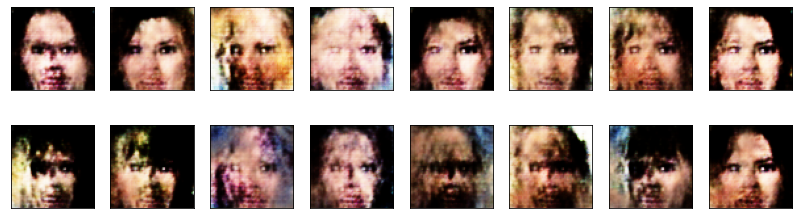

In [26]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        d_loss = discriminator_step(batch_size=batch_size , latent_dim=latent_dim, real_images= real_images)
        
        g_loss = generator_step(batch_size=batch_size, latent_dim=latent_dim)
        
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

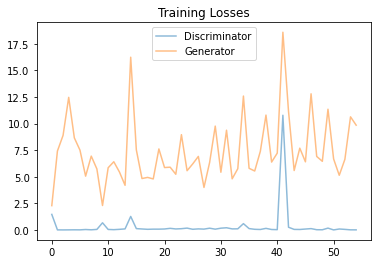

In [27]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** 1- its looks pretty good , at the first epochs during the training, we can notice that only the eyes appeared. then epoch after epoch the other Facial features start appearing .
 
 
 
 2- i tried different learing rate until I reached 0.002 . it was the best one that gets less loss error. then I used diiferent loss functions , I found that the BCE loss gets best results . Also the I used the default letent dimations (128) it gets good result  )

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.